## https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.patches as mpatches

In [2]:
data =pd.read_csv('bank-additional-full.csv',sep=';')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [4]:
data.shape

(41188, 21)

In [5]:
dict_y ={"y":{'yes':1,'no':0}}
data.replace(dict_y,inplace = True)

In [6]:
data=pd.get_dummies(data=data,columns=['job','education','default','housing','loan','contact',
'month','day_of_week','poutcome','marital'])

In [7]:
data.shape

(41188, 64)

In [8]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.2,0.7)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

In [9]:
X = data.drop('y', axis = 1)
y = data['y']

##### LogisticRegression

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=10,
                                                   stratify =y )
clf = LogisticRegression(random_state=42, C=0.01)
clf.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
C = confusion_matrix(y_train,clf.predict(X_train))
training_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
training_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
training_Specifity = C[0,0]/(C[0,1]+C[0,0])

In [12]:
ROC = roc_auc_score(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          0       0.93      0.97      0.95     10965
          1       0.66      0.39      0.49      1392

avg / total       0.90      0.91      0.90     12357



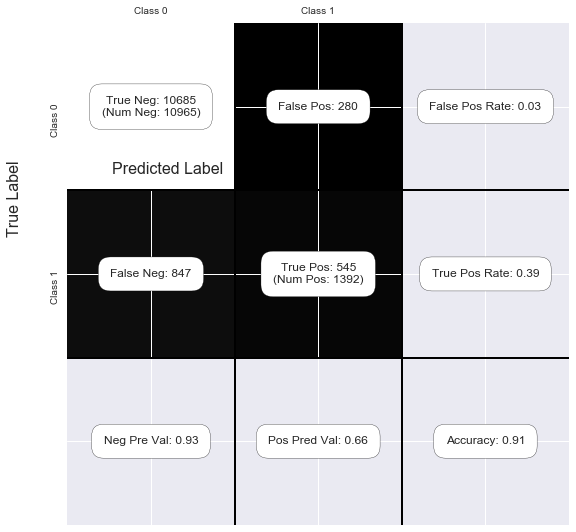

In [13]:
C = confusion_matrix(y_test,clf.predict(X_test))
testing_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
testing_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
testing_Specifity = C[0,0]/(C[0,1]+C[0,0])
final_dict=[{'Model':'LR','Train_A_S':training_Accuracy_score
    ,'Train_TPR':training_Senstivity,
    'Train_TNR':training_Specifity,
    'Test_A_S':testing_Accuracy_score,
    'Test_TPR':testing_Senstivity,
    'Test_TNR':testing_Specifity,
    'ROC':ROC}]
print(classification_report(y_test,clf.predict(X_test)))
show_confusion_matrix(C, ['Class 0', 'Class 1'])
#final_dict

##### KFold Cross Validation

In [14]:
kf = KFold(n_splits=5, shuffle=True)
for train,test in kf.split(X):
    #print("hello")
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    clf = LogisticRegression()
    clf.fit(X_train,y_train)
    print("Accuracy Score {:.3f}".format(accuracy_score(y_test,clf.predict(X_test))))
    C = confusion_matrix(y_test,clf.predict(X_test))
    #show_confusion_matrix(C, ['Class 0', 'Class 1'])
    tpr = C[1,1]/(C[1,0]+C[1,1])
    fpr = C[0,1]/(C[0,1]+C[0,0])
        
    print("FPR {:.3f}".format(fpr))
    print("TPR {:.3f}".format(tpr))
    
    
    
    


crossval_score = cross_val_score(clf,X,y,cv=kf)
print("CrossValScore ",crossval_score.mean())

Accuracy Score 0.908
FPR 0.025
TPR 0.400
Accuracy Score 0.905
FPR 0.028
TPR 0.375
Accuracy Score 0.912
FPR 0.022
TPR 0.390
Accuracy Score 0.913
FPR 0.026
TPR 0.419
Accuracy Score 0.912
FPR 0.028
TPR 0.440
CrossValScore  0.909852352039


##### StratifiedKFold Validation

In [15]:
kf_stratified = StratifiedKFold(n_splits=5, shuffle=True)
for train,test in kf_stratified.split(X,y):
    #print("hello")
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    clf = LogisticRegression()
    clf.fit(X_train,y_train)
    print("Accuracy Score {:.3f}".format(accuracy_score(y_test,clf.predict(X_test))))
    C = confusion_matrix(y_test,clf.predict(X_test))
    tpr = C[1,1]/(C[1,0]+C[1,1])
    fpr = C[0,1]/(C[0,1]+C[0,0])
        #fpr = c[]
    print("FPR {:.3f}".format(fpr))
    print("TPR {:.3f}".format(tpr))
    #show_confusion_matrix(C, ['Class 0', 'Class 1'])
crossval_score = cross_val_score(clf,X,y,cv=kf_stratified)
print("The cross val score is {:.3f}".format(crossval_score.mean()))

Accuracy Score 0.908
FPR 0.025
TPR 0.375
Accuracy Score 0.914
FPR 0.023
TPR 0.420
Accuracy Score 0.909
FPR 0.027
TPR 0.412
Accuracy Score 0.909
FPR 0.026
TPR 0.402
Accuracy Score 0.913
FPR 0.025
TPR 0.431
The cross val score is 0.910


###### GridSearchCV

In [16]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],'penalty':['l1','l2'] }
clf_CV = GridSearchCV(LogisticRegression(), param_grid)

{'C': 0.01, 'penalty': 'l1'}


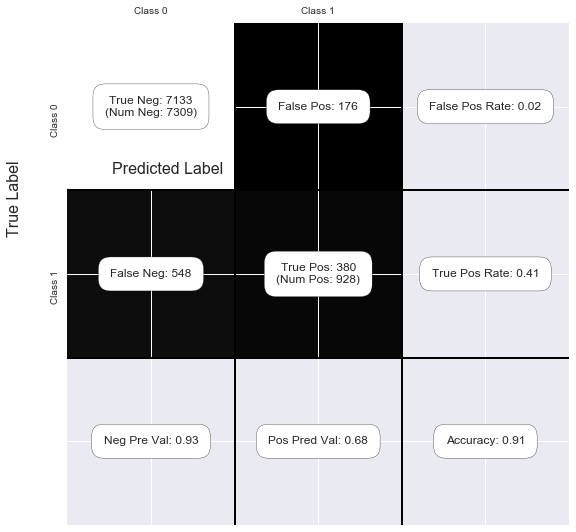

In [17]:
clf_CV.fit(X_train, y_train)
print(clf_CV.best_params_)
C = confusion_matrix(y_test,clf_CV.predict(X_test))
show_confusion_matrix(C, ['Class 0', 'Class 1'])

##### UnderSampling

In [18]:
df_0=data[data['y']==0]

In [19]:
df_0.shape

(36548, 64)

In [20]:
df_1=data[data['y']==1]

In [21]:
df_1.shape

(4640, 64)

In [22]:
df_0.shape

(36548, 64)

In [23]:
chunkSize = 4640
numberChunks = len(df_0)//chunkSize
print(numberChunks)

7


In [24]:
li_tpr = []
li_tnr = []
li_roc =[]
for i in range(numberChunks):
    df_split = df_0[i*chunkSize:(i+1)*chunkSize]
    frames = [df_split,df_1]
    final_df = pd.concat(frames)
    final_df = final_df.sample(frac=1)
    X_underSample = final_df.drop('y', axis = 1)
    y_underSample = final_df['y']
    X_train, X_test, y_train, y_test = train_test_split(X_underSample, y_underSample, 
                                                    test_size=0.3,random_state=10)
    clf = LogisticRegression(C=0.01,max_iter=1000)
    clf.fit(X_train, y_train)
    C = confusion_matrix(y_test,clf.predict(X_test))
    #print(C)
    tpr = C[1,1]/(C[1,0]+C[1,1])
    tnr = C[0,0]/(C[0,1]+C[0,0])
    print("TNR {:.3f}".format(tnr))
    print("TPR {:.3f}".format(tpr))
    li_tpr.append(tpr)
    li_tnr.append(tnr)
    print("ROC Score {:.3f}".format(roc_auc_score(y_test, clf.predict(X_test))))
    li_roc.append(roc_auc_score(y_test, clf.predict(X_test)))
    #print(C)
    #show_confusion_matrix(C, ['Class 0', 'Class 1'])
    #pred = clf.predict(X_test)
    #print(classification_report(y_test,pred))
    print("*******************")
    

TNR 0.986
TPR 0.963
ROC Score 0.975
*******************
TNR 0.973
TPR 0.940
ROC Score 0.957
*******************
TNR 0.979
TPR 0.940
ROC Score 0.959
*******************
TNR 0.963
TPR 0.943
ROC Score 0.953
*******************
TNR 0.981
TPR 0.956
ROC Score 0.968
*******************
TNR 0.963
TPR 0.889
ROC Score 0.926
*******************
TNR 0.961
TPR 0.879
ROC Score 0.920
*******************


In [25]:
li_tpr

[0.96312364425162689,
 0.94013303769401335,
 0.94015861571737558,
 0.94252873563218387,
 0.95571428571428574,
 0.88864942528735635,
 0.87857142857142856]

###### Graph TPR vs TNR for different chunks of data for UnderSampling

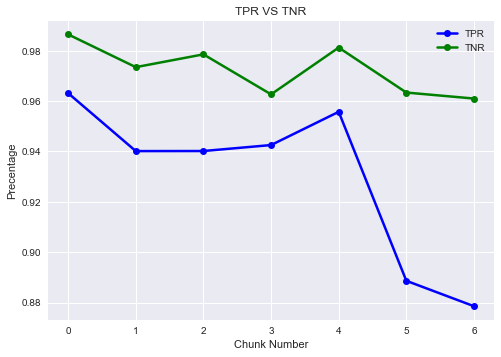

In [26]:
plt.plot(li_tpr,color="blue", linewidth=2.5, linestyle="-",label="TPR",marker='o')
plt.plot(li_tnr,color="green", linewidth=2.5, linestyle="-",label="TNR",marker='o')
plt.legend(loc='upper right')
plt.xlabel("Chunk Number")
plt.ylabel("Precentage")
plt.title("TPR VS TNR")

###### ROC Score for different chunks

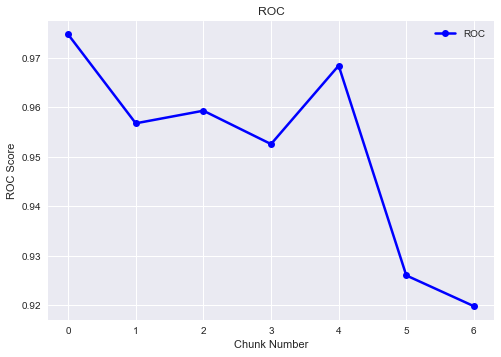

In [27]:
plt.plot(li_roc,color="blue", linewidth=2.5, linestyle="-",label="ROC",marker='o')
plt.legend(loc='upper right')
plt.xlabel("Chunk Number")
plt.ylabel("ROC Score")
plt.title("ROC")

In [28]:
kf_stratified = StratifiedKFold(n_splits=5, shuffle=True)
li_tpr = []
li_tnr = []
li_roc =[]
for i in range(numberChunks):
    df_split = df_0[i*chunkSize:(i+1)*chunkSize]
    frames = [df_split,df_1]
    final_df = pd.concat(frames)
    final_df = final_df.sample(frac=1)
    X_S = final_df.drop('y', axis = 1)
    y_S = final_df['y']
    print("*****************Chunk*********************",i)
    for train,test in kf_stratified.split(X_S,y_S):
    #print("hello")
        X_train, X_test = X_S.iloc[train], X_S.iloc[test]
        y_train, y_test = y_S.iloc[train], y_S.iloc[test]
        clf = LogisticRegression(C=0.01)
        clf.fit(X_train,y_train)
        print("Accuracy Score {:.3f}".format(accuracy_score(y_test,clf.predict(X_test))))
        C = confusion_matrix(y_test,clf.predict(X_test))
        tpr = C[1,1]/(C[1,0]+C[1,1])
        fpr = C[0,1]/(C[0,1]+C[0,0])
        li_tpr.append(tpr)
        li_tnr.append(tnr)
        #fpr = c[]
        print("TNR {:.3f}".format(tnr))
        print("TPR {:.3f}".format(tpr))
        print("ROC Score {:.3f}".format(roc_auc_score(y_test, clf.predict(X_test))))
        li_roc.append(roc_auc_score(y_test, clf.predict(X_test)))
        #pred = clf.predict(X_test)
        #print(classification_report(y_test,clf.predict(X_test)))
        #print(C)
        #show_confusion_matrix(C, ['Class 0', 'Class 1'])
    


*****************Chunk********************* 0
Accuracy Score 0.969
TNR 0.961
TPR 0.956
ROC Score 0.969
Accuracy Score 0.976
TNR 0.961
TPR 0.968
ROC Score 0.976
Accuracy Score 0.971
TNR 0.961
TPR 0.954
ROC Score 0.971
Accuracy Score 0.977
TNR 0.961
TPR 0.971
ROC Score 0.977
Accuracy Score 0.979
TNR 0.961
TPR 0.968
ROC Score 0.979
*****************Chunk********************* 1
Accuracy Score 0.964
TNR 0.961
TPR 0.944
ROC Score 0.964
Accuracy Score 0.953
TNR 0.961
TPR 0.932
ROC Score 0.953
Accuracy Score 0.968
TNR 0.961
TPR 0.954
ROC Score 0.968
Accuracy Score 0.962
TNR 0.961
TPR 0.949
ROC Score 0.962
Accuracy Score 0.960
TNR 0.961
TPR 0.945
ROC Score 0.960
*****************Chunk********************* 2
Accuracy Score 0.952
TNR 0.961
TPR 0.922
ROC Score 0.952
Accuracy Score 0.959
TNR 0.961
TPR 0.952
ROC Score 0.959
Accuracy Score 0.966
TNR 0.961
TPR 0.955
ROC Score 0.966
Accuracy Score 0.955
TNR 0.961
TPR 0.936
ROC Score 0.955
Accuracy Score 0.956
TNR 0.961
TPR 0.939
ROC Score 0.956
*******

###### RandomForestClassifier

In [29]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=10)
rfc = RandomForestClassifier(class_weight="balanced",n_jobs=2)
param_grid ={'n_estimators': [200, 700],
             'max_features': ['auto', 'sqrt', 'log2']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid)
CV_rfc.fit(X_train, y_train)
print(X_train.shape)
print(CV_rfc.best_params_)
 

(28831, 63)
{'max_features': 'auto', 'n_estimators': 200}


In [30]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
rfc.feature_importances_.argsort()

array([32, 26, 43, 62, 21, 37, 48, 50, 34, 42, 13, 44, 20, 18, 29, 12, 16,
       23, 45, 14, 56, 17, 41,  4, 15, 59, 22, 31, 27, 24, 39, 46, 19, 30,
       36, 38, 54, 55, 25, 11, 53, 10, 60, 51, 52, 49, 35, 61, 33, 40, 28,
       57, 47,  3,  6, 58,  2,  7,  9,  0,  8,  5,  1])

In [32]:
data.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu

In [33]:
C = confusion_matrix(y_train,CV_rfc.predict(X_train))
training_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
training_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
training_Specifity = C[0,0]/(C[0,1]+C[0,0])

In [34]:
ROC = roc_auc_score(y_test, CV_rfc.predict(X_test))

In [35]:
#pred = clf.predict(X_test)
C = confusion_matrix(y_test,CV_rfc.predict(X_test))
#show_confusion_matrix(C, ['Class 0', 'Class 1'])
tpr = C[1,1]/(C[1,0]+C[1,1])
tnr = C[0,0]/(C[0,1]+C[0,0])
print("TNR {:.3f}".format(tnr))
print("TPR {:.3f}".format(tpr))
#pred = clf.predict(X_test)
print(classification_report(y_test,CV_rfc.predict(X_test)))
#print(classification_report(y_test,pred))
testing_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
testing_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
testing_Specifity = C[0,0]/(C[0,1]+C[0,0])
final_dict.append({'Model':'RFC','Train_A_S':training_Accuracy_score
    ,'Train_TPR':training_Senstivity,
    'Train_TNR':training_Specifity,
    'Test_A_S':testing_Accuracy_score,
    'Test_TPR':testing_Senstivity,
    'Test_TNR':testing_Specifity,
    'ROC':ROC})

TNR 0.977
TPR 0.385
             precision    recall  f1-score   support

          0       0.92      0.98      0.95     10935
          1       0.68      0.38      0.49      1422

avg / total       0.90      0.91      0.90     12357



###### UnderSampling for Random Forest

In [36]:
li_tpr = []
li_tnr = []
li_roc =[]
for i in range(numberChunks):
    df_split = df_0[i*chunkSize:(i+1)*chunkSize]
    frames = [df_split,df_1]
    final_df = pd.concat(frames)
    final_df = final_df.sample(frac=1)
    X_underSample = final_df.drop('y', axis = 1)
    y_underSample = final_df['y']
    X_train, X_test, y_train, y_test = train_test_split(X_underSample, y_underSample, 
                                            test_size=0.3,random_state=10)
    rfc = RandomForestClassifier(class_weight="balanced",n_jobs=2,
                    n_estimators=200,max_features='auto')
    rfc.fit(X_train,y_train)
    C = confusion_matrix(y_test,rfc.predict(X_test))
    #print(C)
    tpr = C[1,1]/(C[1,0]+C[1,1])
    tnr = C[0,0]/(C[0,1]+C[0,0])
    print("TNR {:.3f}".format(tnr))
    print("TPR {:.3f}".format(tpr))
    li_tpr.append(tpr)
    li_tnr.append(tnr)
    print("ROC Score {:.3f}".format(roc_auc_score(y_test, rfc.predict(X_test))))
    li_roc.append(roc_auc_score(y_test, rfc.predict(X_test)))
    #print(C)
    #show_confusion_matrix(C, ['Class 0', 'Class 1'])
    #pred = clf.predict(X_test)
    #print(classification_report(y_test,pred))
    print("*******************")
    

TNR 0.998
TPR 0.957
ROC Score 0.978
*******************
TNR 0.986
TPR 0.963
ROC Score 0.975
*******************
TNR 0.985
TPR 0.940
ROC Score 0.962
*******************
TNR 0.983
TPR 0.943
ROC Score 0.963
*******************
TNR 0.988
TPR 0.956
ROC Score 0.972
*******************
TNR 0.986
TPR 0.901
ROC Score 0.944
*******************
TNR 0.961
TPR 0.916
ROC Score 0.938
*******************


###### TPR vs TNR for Random Forest Sampler

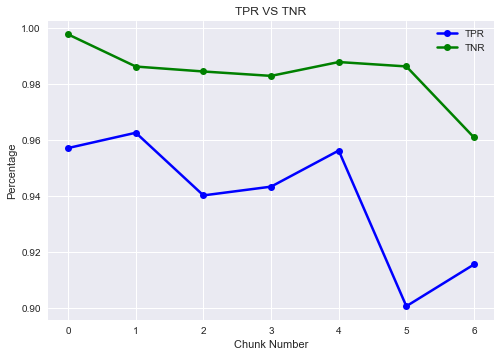

In [37]:
plt.plot(li_tpr,color="blue", linewidth=2.5, linestyle="-",label="TPR",marker='o')
plt.plot(li_tnr,color="green", linewidth=2.5, linestyle="-",label="TNR",marker='o')
plt.legend(loc='upper right')
plt.xlabel("Chunk Number")
plt.ylabel("Percentage")
plt.title("TPR VS TNR")

###### ROC Score Random Forest for Different Chunks

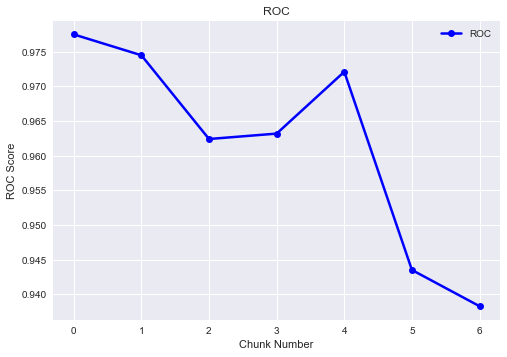

In [38]:
plt.plot(li_roc,color="blue", linewidth=2.5, linestyle="-",label="ROC",marker = 'o')
plt.legend(loc='upper right')
plt.xlabel("Chunk Number")
plt.ylabel("ROC Score")
plt.title("ROC")

###### ADABoostClassifier

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                    test_size=0.3,random_state=10)

adaBoost = AdaBoostClassifier(n_estimators=50,learning_rate=1.0, algorithm='SAMME')
adaBoost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
          n_estimators=50, random_state=None)

In [40]:
C = confusion_matrix(y_train,adaBoost.predict(X_train))
training_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
training_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
training_Specifity = C[0,0]/(C[0,1]+C[0,0])

In [41]:
ROC = roc_auc_score(y_test, adaBoost.predict(X_test))

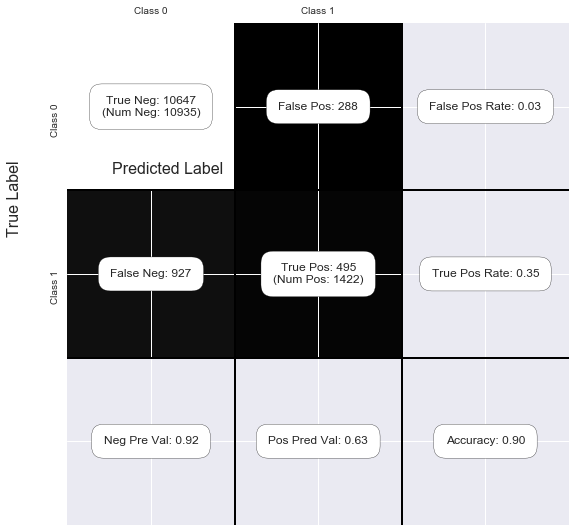

In [42]:
C = confusion_matrix(y_test,adaBoost.predict(X_test))
show_confusion_matrix(C, ['Class 0', 'Class 1'])
testing_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
testing_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
testing_Specifity = C[0,0]/(C[0,1]+C[0,0])
final_dict.append({'Model':'ADABoost','Train_A_S':training_Accuracy_score
    ,'Train_TPR':training_Senstivity,
    'Train_TNR':training_Specifity,
    'Test_A_S':testing_Accuracy_score,
    'Test_TPR':testing_Senstivity,
    'Test_TNR':testing_Specifity,
    'ROC':ROC})

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                    test_size=0.3,random_state=10)
gbt = GradientBoostingClassifier(n_estimators=200, max_depth=3)
gbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [44]:
#gbt.estimators_
C = confusion_matrix(y_train,gbt.predict(X_train))
training_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
training_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
training_Specifity = C[0,0]/(C[0,1]+C[0,0])


In [45]:
ROC = roc_auc_score(y_test, gbt.predict(X_test))

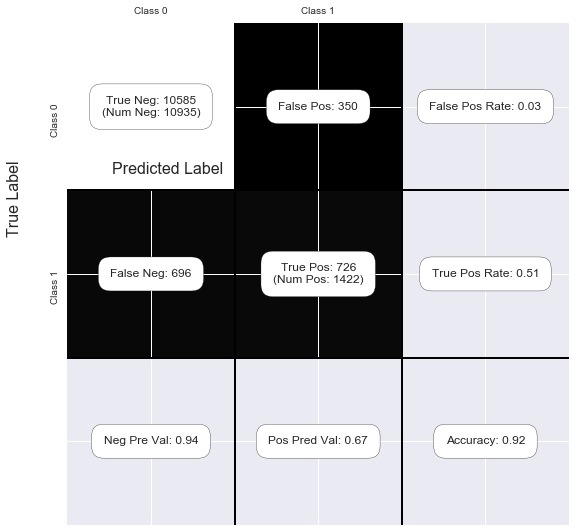

In [46]:
C = confusion_matrix(y_test,gbt.predict(X_test))
show_confusion_matrix(C, ['Class 0', 'Class 1'])
testing_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
testing_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
testing_Specifity = C[0,0]/(C[0,1]+C[0,0])
final_dict.append({'Model':'GBT','Train_A_S':training_Accuracy_score
    ,'Train_TPR':training_Senstivity,
    'Train_TNR':training_Specifity,
    'Test_A_S':testing_Accuracy_score,
    'Test_TPR':testing_Senstivity,
    'Test_TNR':testing_Specifity,
    'ROC':ROC})

###### OverSampling

In [47]:
X.shape

(41188, 63)

In [48]:
y.shape

(41188,)

###### SMOTE

In [49]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [50]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)

In [51]:
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 36548, 1: 36548})


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3,random_state=10)
clf = LogisticRegression(C=0.01,max_iter = 1000)
clf.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
C = confusion_matrix(y_train,clf.predict(X_train))
training_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
training_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
training_Specifity = C[0,0]/(C[0,1]+C[0,0])

In [54]:
ROC = roc_auc_score(y_test, clf.predict(X_test))

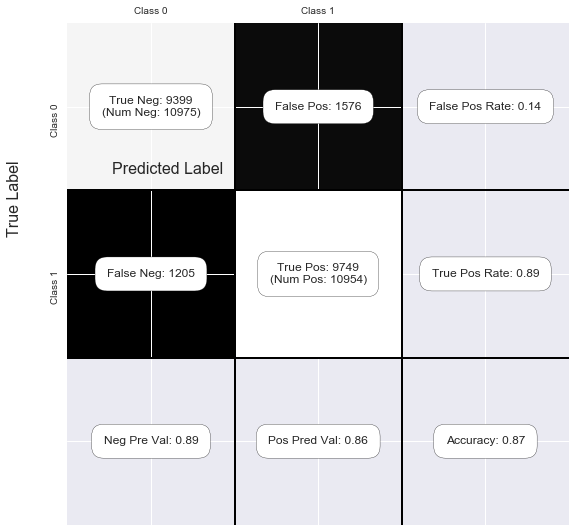

In [55]:
C = confusion_matrix(y_test,clf.predict(X_test))
show_confusion_matrix(C, ['Class 0', 'Class 1'])
testing_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
testing_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
testing_Specifity = C[0,0]/(C[0,1]+C[0,0])
final_dict.append({'Model':'SMOTE_LR','Train_A_S':training_Accuracy_score
    ,'Train_TPR':training_Senstivity,
    'Train_TNR':training_Specifity,
    'Test_A_S':testing_Accuracy_score,
    'Test_TPR':testing_Senstivity,
    'Test_TNR':testing_Specifity,
    'ROC':ROC})

###### RandomOverSampler

In [56]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res_ros, y_res_ros = ros.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res_ros)))

Resampled dataset shape Counter({0: 36548, 1: 36548})


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_res_ros, y_res_ros, 
                                        test_size=0.3,random_state=10)
clf = LogisticRegression(C=.01,max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

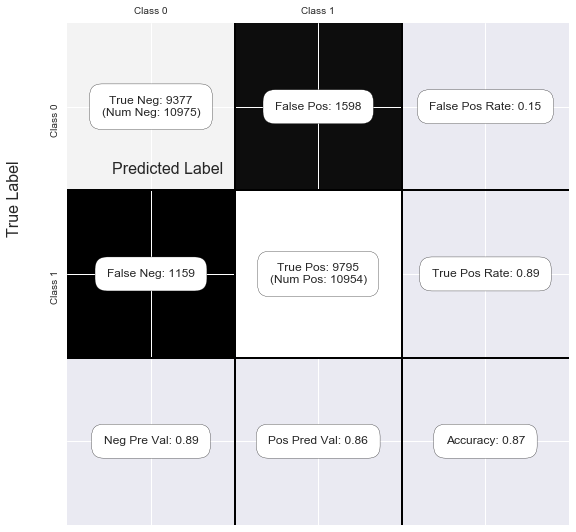

In [58]:
C = confusion_matrix(y_test,clf.predict(X_test))
show_confusion_matrix(C, ['Class 0', 'Class 1'])

###### ADASYN

In [59]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
X_res_ada, y_res_ada = adasyn.fit_sample(X, y)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_res_ada, y_res_ada, 
                                        test_size=0.3,random_state=10)
clf = LogisticRegression(C=.01,max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

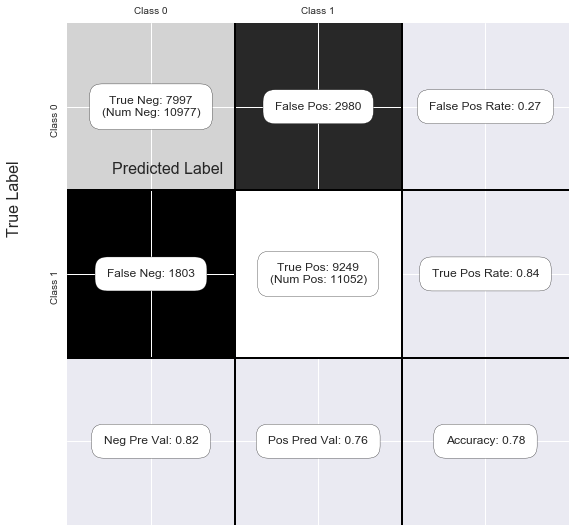

In [61]:
C = confusion_matrix(y_test,clf.predict(X_test))
show_confusion_matrix(C, ['Class 0', 'Class 1'])

###### RandomUnderSampler

In [62]:
from imblearn.under_sampling import RandomUnderSampler

In [63]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_sample(X, y)

In [64]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 36548, 1: 4640})
Resampled dataset shape Counter({0: 4640, 1: 4640})


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                    test_size=0.3,random_state=10)
gbt = GradientBoostingClassifier(n_estimators=200, max_depth=3)
gbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [66]:
C = confusion_matrix(y_train,gbt.predict(X_train))
training_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
training_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
training_Specifity = C[0,0]/(C[0,1]+C[0,0])

In [67]:
ROC = roc_auc_score(y_test, gbt.predict(X_test))

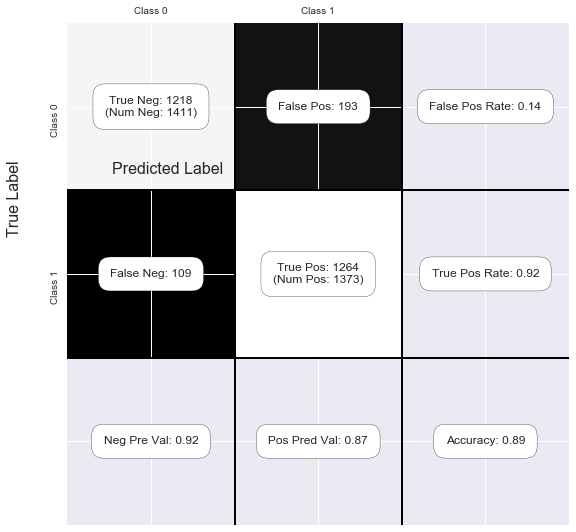

TPR 0.921
TNR 0.863


In [68]:
C = confusion_matrix(y_test,gbt.predict(X_test))
show_confusion_matrix(C, ['Class 0', 'Class 1'])
tpr = C[1,1]/(C[1,0]+C[1,1])
tnr = C[0,0]/(C[0,1]+C[0,0])
print("TPR {:.3f}".format(tpr))
print("TNR {:.3f}".format(tnr))
testing_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
testing_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
testing_Specifity = C[0,0]/(C[0,1]+C[0,0])
final_dict.append({'Model':'UnderSler_GBT','Train_A_S':training_Accuracy_score
    ,'Train_TPR':training_Senstivity,
    'Train_TNR':training_Specifity,
    'Test_A_S':testing_Accuracy_score,
    'Test_TPR':testing_Senstivity,
    'Test_TNR':testing_Specifity,
    'ROC':ROC})

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                        test_size=0.3,random_state=10)
clf = LogisticRegression(C=.01,max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
C = confusion_matrix(y_train,clf.predict(X_train))
training_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
training_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
training_Specifity = C[0,0]/(C[0,1]+C[0,0])

In [71]:
ROC = roc_auc_score(y_test, clf.predict(X_test))

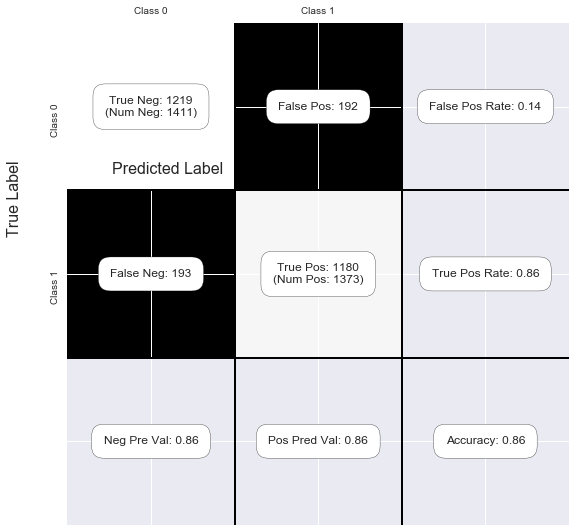

TPR 0.859
TNR 0.864


In [72]:
C = confusion_matrix(y_test,clf.predict(X_test))
show_confusion_matrix(C, ['Class 0', 'Class 1'])
tpr = C[1,1]/(C[1,0]+C[1,1])
tnr = C[0,0]/(C[0,1]+C[0,0])
print("TPR {:.3f}".format(tpr))
print("TNR {:.3f}".format(tnr))
testing_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
testing_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
testing_Specifity = C[0,0]/(C[0,1]+C[0,0])
final_dict.append({'Model':'UnderSler_LR','Train_A_S':training_Accuracy_score
    ,'Train_TPR':training_Senstivity,
    'Train_TNR':training_Specifity,
    'Test_A_S':testing_Accuracy_score,
    'Test_TPR':testing_Senstivity,
    'Test_TNR':testing_Specifity,
        'ROC':ROC})

###### XGBoost

In [73]:
from xgboost import XGBClassifier

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                test_size=0.3,random_state=10,stratify=y)

In [75]:
xgbc = XGBClassifier( learning_rate =0.01, n_estimators=5000, max_depth=5,
 min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27,
                   reg_alpha=0.001)
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0.3, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=3, missing=None,
       n_estimators=5000, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8)

In [76]:
C = confusion_matrix(y_train,xgbc.predict(X_train))
training_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
training_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
training_Specifity = C[0,0]/(C[0,1]+C[0,0])

In [77]:
ROC = roc_auc_score(y_test, xgbc.predict(X_test))

In [78]:
C = confusion_matrix(y_test,xgbc.predict(X_test))
#show_confusion_matrix(C, ['Class 0', 'Class 1'])
tpr = C[1,1]/(C[1,0]+C[1,1])
tnr = C[0,0]/(C[0,1]+C[0,0])
print("TPR {:.3f}".format(tpr))
print("TNR {:.3f}".format(tnr))
testing_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
testing_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
testing_Specifity = C[0,0]/(C[0,1]+C[0,0])

TPR 0.550
TNR 0.965


In [79]:
final_dict.append({'Model':'XGBoost','Train_A_S':training_Accuracy_score
    ,'Train_TPR':training_Senstivity,
    'Train_TNR':training_Specifity,
    'Test_A_S':testing_Accuracy_score,
    'Test_TPR':testing_Senstivity,
    'Test_TNR':testing_Specifity,
        'ROC':ROC})

###### OverSampler For XGBoost

In [80]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)

In [81]:
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 36548, 1: 36548})


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3,
                                                    random_state=10)


In [83]:
xgbc = XGBClassifier( learning_rate =0.01, n_estimators=5000, max_depth=5,
 min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27,
                   reg_alpha=0.001)
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0.3, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=3, missing=None,
       n_estimators=5000, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8)

In [84]:
C = confusion_matrix(y_train,xgbc.predict(X_train))
training_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
training_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
training_Specifity = C[0,0]/(C[0,1]+C[0,0])

In [85]:
ROC = roc_auc_score(y_test, xgbc.predict(X_test))

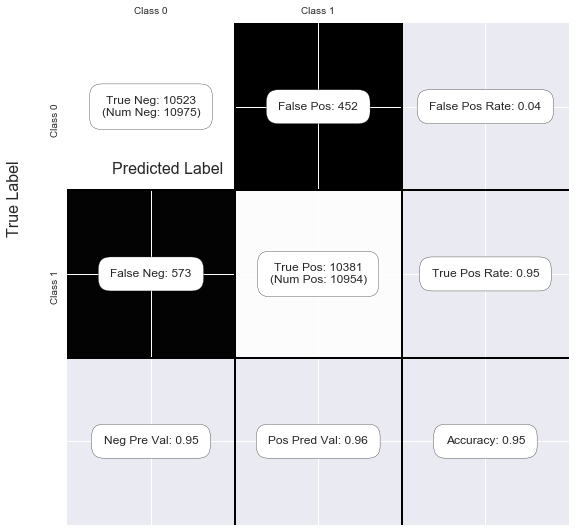

In [86]:
C = confusion_matrix(y_test,xgbc.predict(X_test))
show_confusion_matrix(C, ['Class 0', 'Class 1'])
testing_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
testing_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
testing_Specifity = C[0,0]/(C[0,1]+C[0,0])
final_dict.append({'Model':'SMOTE_XGB','Train_A_S':training_Accuracy_score
    ,'Train_TPR':training_Senstivity,
    'Train_TNR':training_Specifity,
    'Test_A_S':testing_Accuracy_score,
    'Test_TPR':testing_Senstivity,
    'Test_TNR':testing_Specifity,
    'ROC':ROC})

###### RandomUnderSampler for XGBoost

In [87]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_sample(X, y)

In [88]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 36548, 1: 4640})
Resampled dataset shape Counter({0: 4640, 1: 4640})


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                    test_size=0.3,random_state=10)


In [90]:
xgbc = XGBClassifier( learning_rate =0.01, n_estimators=5000, max_depth=5,
 min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27,
                   reg_alpha=0.001)
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0.3, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=3, missing=None,
       n_estimators=5000, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8)

In [91]:
C = confusion_matrix(y_train,xgbc.predict(X_train))
training_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
training_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
training_Specifity = C[0,0]/(C[0,1]+C[0,0])

In [92]:
ROC = roc_auc_score(y_test, xgbc.predict(X_test))

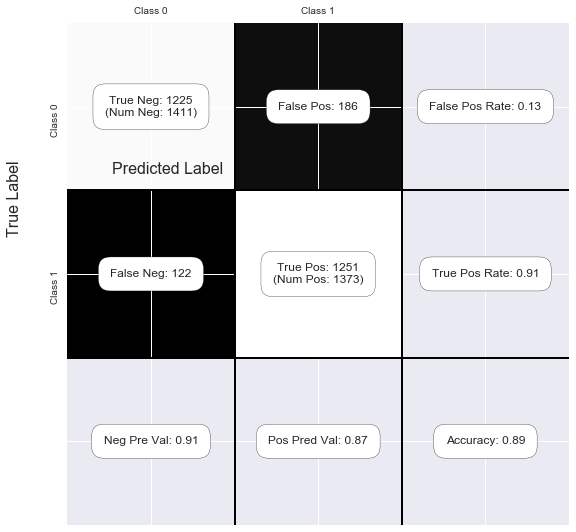

TPR 0.911
TNR 0.868


In [93]:
C = confusion_matrix(y_test,xgbc.predict(X_test))
show_confusion_matrix(C, ['Class 0', 'Class 1'])
tpr = C[1,1]/(C[1,0]+C[1,1])
tnr = C[0,0]/(C[0,1]+C[0,0])
print("TPR {:.3f}".format(tpr))
print("TNR {:.3f}".format(tnr))
testing_Accuracy_score = ((C[0,0]+C[1,1])/(C[0,0]+C[0,1]+C[1,0]+C[1,1]))
testing_Senstivity =  C[1,1]/(C[1,0]+C[1,1])
testing_Specifity = C[0,0]/(C[0,1]+C[0,0])
final_dict.append({'Model':'UnderSler_XGB','Train_A_S':training_Accuracy_score
    ,'Train_TPR':training_Senstivity,
    'Train_TNR':training_Specifity,
    'Test_A_S':testing_Accuracy_score,
    'Test_TPR':testing_Senstivity,
    'Test_TNR':testing_Specifity,
    'ROC':ROC})

In [94]:
results = pd.DataFrame(final_dict)

In [95]:
results

,Model,ROC,Test_A_S,Test_TNR,Test_TPR,Train_A_S,Train_TNR,Train_TPR
0,LR,0.682994,0.908797,0.974464,0.391523,0.909611,0.975062,0.394089
1,RFC,0.680812,0.908797,0.976955,0.384669,1.000000,1.000000,1.000000
2,ADABoost,0.660882,0.901675,0.973663,0.348101,0.906594,0.974544,0.365755
3,GBT,0.739271,0.915352,0.967993,0.510549,0.928272,0.972631,0.575202
4,SMOTE_LR,0.873198,0.873182,0.856401,0.889995,0.875388,0.858562,0.892201
5,UnderSler_GBT,0.891915,0.891523,0.863218,0.920612,0.914717,0.877671,0.951331
6,UnderSler_LR,0.861679,0.861710,0.863926,0.859432,0.873307,0.859709,0.886746
7,XGBoost,0.757588,0.918184,0.964888,0.550287,0.962367,0.987883,0.761392
8,SMOTE_XGB,0.953253,0.953258,0.958815,0.947690,0.977876,0.986509,0.969251
9,UnderSler_XGB,0.889661,0.889368,0.868179,0.911143,0.973060,0.959120,0.986838


In [96]:
algo_withOutresampling = results.loc[[0, 1, 2, 3, 7]]

In [97]:
algo_withOutresampling

,Model,ROC,Test_A_S,Test_TNR,Test_TPR,Train_A_S,Train_TNR,Train_TPR
0,LR,0.682994,0.908797,0.974464,0.391523,0.909611,0.975062,0.394089
1,RFC,0.680812,0.908797,0.976955,0.384669,1.000000,1.000000,1.000000
2,ADABoost,0.660882,0.901675,0.973663,0.348101,0.906594,0.974544,0.365755
3,GBT,0.739271,0.915352,0.967993,0.510549,0.928272,0.972631,0.575202
7,XGBoost,0.757588,0.918184,0.964888,0.550287,0.962367,0.987883,0.761392


In [98]:
algo_withOutresampling = algo_withOutresampling.set_index('Model')

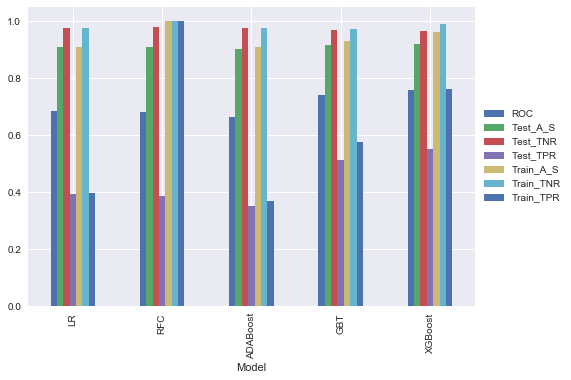

In [99]:
algo_withOutresampling.plot(kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [100]:
algo_resampling = results.loc[[4, 5, 6, 8, 9]]

In [101]:
algo_resampling = algo_resampling.set_index('Model')

In [102]:
algo_resampling

,ROC,Test_A_S,Test_TNR,Test_TPR,Train_A_S,Train_TNR,Train_TPR
Model,,,,,,,
SMOTE_LR,0.873198,0.873182,0.856401,0.889995,0.875388,0.858562,0.892201
UnderSler_GBT,0.891915,0.891523,0.863218,0.920612,0.914717,0.877671,0.951331
UnderSler_LR,0.861679,0.861710,0.863926,0.859432,0.873307,0.859709,0.886746
SMOTE_XGB,0.953253,0.953258,0.958815,0.947690,0.977876,0.986509,0.969251
UnderSler_XGB,0.889661,0.889368,0.868179,0.911143,0.973060,0.959120,0.986838


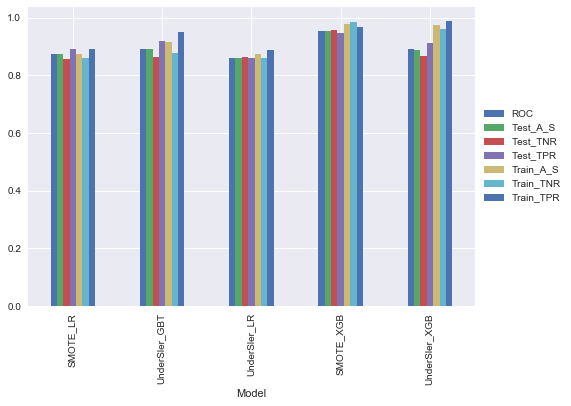

In [103]:
algo_resampling.plot(kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [104]:
results

,Model,ROC,Test_A_S,Test_TNR,Test_TPR,Train_A_S,Train_TNR,Train_TPR
0,LR,0.682994,0.908797,0.974464,0.391523,0.909611,0.975062,0.394089
1,RFC,0.680812,0.908797,0.976955,0.384669,1.000000,1.000000,1.000000
2,ADABoost,0.660882,0.901675,0.973663,0.348101,0.906594,0.974544,0.365755
3,GBT,0.739271,0.915352,0.967993,0.510549,0.928272,0.972631,0.575202
4,SMOTE_LR,0.873198,0.873182,0.856401,0.889995,0.875388,0.858562,0.892201
5,UnderSler_GBT,0.891915,0.891523,0.863218,0.920612,0.914717,0.877671,0.951331
6,UnderSler_LR,0.861679,0.861710,0.863926,0.859432,0.873307,0.859709,0.886746
7,XGBoost,0.757588,0.918184,0.964888,0.550287,0.962367,0.987883,0.761392
8,SMOTE_XGB,0.953253,0.953258,0.958815,0.947690,0.977876,0.986509,0.969251
9,UnderSler_XGB,0.889661,0.889368,0.868179,0.911143,0.973060,0.959120,0.986838


###### Conclusion-XGBoost is the best model to predict the response variable y. It gives the highest TPR out of all models without using any resampling techniques.

In [105]:
results = results.set_index('Model')

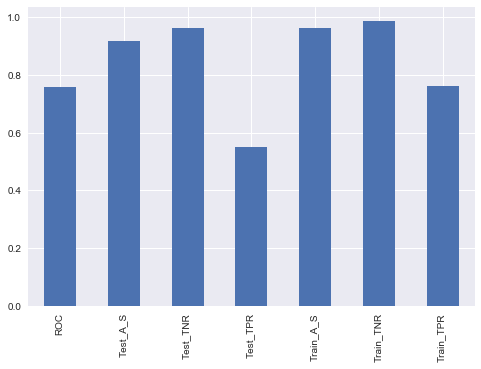

In [106]:
results.loc['XGBoost'].plot(kind = 'bar')
#results.loc['SMOTE_XGB'].plot(kind = 'bar')

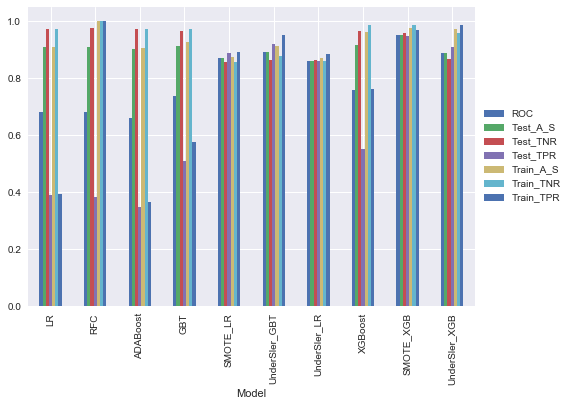

In [107]:
results.plot(kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [108]:
x = results.loc['SMOTE_XGB'].to_dict()
smote = pd.DataFrame([x])
smote.rename(index={0:'Smote_XGB'},inplace=True)

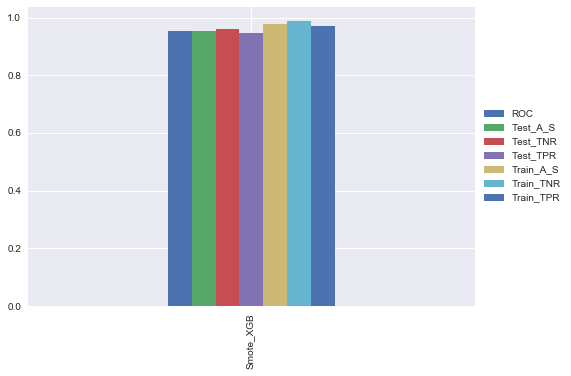

In [109]:

smote.plot(kind='bar',width=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


In [110]:
smote_xgb=pd.DataFrame(results.loc['SMOTE_XGB'])
smote_xgb

,SMOTE_XGB
ROC,0.953253
Test_A_S,0.953258
Test_TNR,0.958815
Test_TPR,0.947690
Train_A_S,0.977876
Train_TNR,0.986509
Train_TPR,0.969251


###### Conclusion-XGBoost using OverSampling gives us best TPR and TNR

In [111]:
#result Comparison with Hany A. Elsalamony

![title](Img.jpg)

In [112]:
#Result Comparison with Prusty Sagariska

![title](Img1.png)